In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [3]:
# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [4]:
from sklearn.preprocessing import StandardScaler

def seq_to_tensor(seq, scaler: StandardScaler):
    seq = scaler.transform(seq)
    return torch.tensor(seq, dtype=torch.float32).reshape((-1, 1, 2))

class ChartDataset(Dataset):

    def __init__(self, X, y, scaler):
        self.X_tensors = list(map(lambda seq: seq_to_tensor(seq, scaler), X))
        self.y_tensors = list(map(
            lambda m: torch.tensor([[m]], dtype=torch.float32),
            y
        ))
    
    def __len__(self):
        return len(self.X_tensors)
    
    def __getitem__(self, i):
        return self.X_tensors[i], self.y_tensors[i]

In [5]:
import json
df = pd.read_csv('rnn2_dataset.csv')
df['Sequence'] = df['Sequence'].apply(json.loads)
print(f'loaded {len(df)} items')
# print(f'example = {all_data[0]}')

loaded 3108 items


In [11]:
from itertools import chain

def augment(row):
    orig_seq = row['Sequence']
    data = []
    def make_row(seq):
        data.append([row['Name'], row['Hash'], row['Meter'], seq])
    make_row(orig_seq)

    if orig_seq[0][0] == 0.0:
        make_row(orig_seq[1:])
        if orig_seq[-1][0] == 0.0:
            make_row(orig_seq[1:-1])
    if orig_seq[-1][0] == 0.0:
        make_row(orig_seq[:-1])
    
    return data

aug_data = df.apply(augment, axis=1)
aug_df = pd.DataFrame(chain.from_iterable(aug_data), columns=['Name', 'Hash', 'Meter', 'Sequence'])
print(len(aug_df))
#aug_df.head(20)

8230


In [13]:
from sklearn.model_selection import train_test_split

X_all, y_all = aug_df['Sequence'], aug_df['Meter']
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=1
)

# train_set, test_set = torch.utils.data.random_split(all_data, [.8, .2], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(X_train)}, validation examples = {len(X_test)}")
print(X_train.shape)

train examples = 6584, validation examples = 1646
(6584,)


In [14]:
from sklearn.preprocessing import StandardScaler

concat_X_train = np.concatenate(X_train.to_list()).reshape((-1, 2))
print(concat_X_train.shape)
scaler = StandardScaler()
scaler.fit(concat_X_train)
print(scaler.mean_, scaler.var_)


(354991, 2)
[5.92700428 1.81789331] [24.27809768  1.41118087]


In [15]:
class RatingPairRNN(nn.Module):
    '''Basic RNN'''
    def __init__(self, hidden_size):
        super(RatingPairRNN, self).__init__()

        self.rnn = nn.RNN(2, hidden_size, nonlinearity='relu')
        self.h2o = nn.Linear(hidden_size, 1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])

        return output

class RatingPairLSTM(nn.Module):
    def __init__(self, hidden_size):
        super(RatingPairLSTM, self).__init__()

        self.lstm = nn.LSTM(2, hidden_size)
        self.h2o = nn.Linear(hidden_size, 1)

    def forward(self, seq):
        lstm_out, (h_n, h_c) = self.lstm(seq)
        out = self.h2o(h_n)
        return out.reshape((1, 1))

class RatingPairLSTM2(nn.Module):
    def __init__(self, hidden_size, h2o_size):
        super(RatingPairLSTM2, self).__init__()

        self.lstm = nn.LSTM(2, hidden_size)
        self.h2o = nn.Sequential(
            nn.Linear(hidden_size, h2o_size),
            nn.ReLU(),
            nn.Linear(h2o_size, 1)
        )

    def forward(self, seq):
        lstm_out, (h_n, h_c) = self.lstm(seq)
        out = self.h2o(h_n)
        return out.reshape((1, 1))

In [54]:
import random
from torch.utils.data import DataLoader

class RatingPairRNNClassifier:
    def __init__(self, model: nn.Module, scaler, lr, best_ckp_path='./best.pt'):
        self.model = model
        self.train_losses = []
        self.test_losses = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.scaler = scaler
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.total_epochs = 0
        self.best_test_acc = 0
        self.best_ckp_path = best_ckp_path
    
    def train(
        self,
        X_train, y_train,
        X_test, y_test,
        n_epochs,
        batch_size
    ):
        loss_fn = nn.MSELoss()
        dataset = ChartDataset(X_train, y_train, self.scaler)
        test_dataset = ChartDataset(X_test, y_test, self.scaler)
        size = len(dataset)
        # self.train_losses = []
        # self.test_losses = []
        # self.train_accuracy = []
        # self.test_accuracy = []

        for epoch_i in range(self.total_epochs, self.total_epochs + n_epochs):
            print(f"Epoch {epoch_i+1}")
            self.model.train()
            self.model.zero_grad()
            current_loss, correct = 0, 0

            batches = list(range(len(dataset)))
            random.shuffle(batches)
            batches = np.array_split(batches, len(batches) // batch_size )
            for idx, batch in enumerate(batches):
                batch_loss = 0
                for i in batch:
                    (X, y) = dataset[i]
                    pred = self.model.forward(X)
                    loss = loss_fn(pred, y)
                    batch_loss += loss
                    if round(pred.item()) == round(y.item()):
                        correct += 1
                
                batch_loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), 20)
                self.optimizer.step()
                self.optimizer.zero_grad()

                current_loss += batch_loss.item() / len(batch)
            
            current_loss /= len(batches)
            correct /= size
            self.train_losses.append(current_loss)
            self.train_accuracy.append(correct)
            print(f"Train Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {current_loss:>8f}")
            current_loss = 0
            self.total_epochs += 1
            
            self.test_with_dataset(test_dataset, loss_fn)

    
    def test_with_dataset(self, dataset, loss_fn):
        current_loss, correct = 0, 0
        size = len(dataset)
        self.model.eval()
        with torch.no_grad():
            for X, y in dataset:
                pred = self.model.forward(X)
                loss = loss_fn(pred, y)
                current_loss += loss
                if round(pred.item()) == round(y.item()):
                    correct += 1
        current_loss /= size
        correct /= size
        self.test_losses.append(current_loss)
        self.test_accuracy.append(correct)
        print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {current_loss:>8f}")
        # save best model
        if correct > self.best_test_acc:
            print(f'Saving best model at {self.best_ckp_path}')
            self.best_test_acc = correct
            self.save_ckp(self.best_ckp_path)

    def predict(self, X_test):
        self.model.eval() #set to eval mode
        with torch.no_grad(): # do not record the gradients during eval phase
            preds = []
            for X in X_test:
                X = seq_to_tensor(X, self.scaler)
                preds.append(self.model(X).item())
        return preds
    
    def save_ckp(self, path):
        ckp = {
            'model': self.model.state_dict(),
            'n_epochs': self.total_epochs,
            'best_test_acc': self.best_test_acc,
            'optimizer': self.optimizer.state_dict()
        }
        torch.save(ckp, path)
    
    def load_ckp(self, path):
        ckp = torch.load(path)
        self.model.load_state_dict(ckp['model'])
        self.optimizer.load_state_dict(ckp['optimizer'])
        self.best_test_acc = ckp['best_test_acc']
        self.total_epochs = ckp['n_epochs']


In [57]:
classifier = RatingPairRNNClassifier(
    RatingPairLSTM(128), scaler, 3e-4, 'checkpoints/npslentest/model5_best.pt'
)

In [58]:
# classifier.model.load_state_dict(torch.load(
#     'checkpoints/rnn2_scalertest_128_300_64_1e-3.pt',
#     weights_only=True
# ))
classifier.load_ckp(classifier.best_ckp_path)
print(classifier.best_test_acc, classifier.total_epochs)

0.038882138517618466 2


In [ ]:
classifier.train(
    X_train, y_train, X_test, y_test, 300, 64
)

In [ ]:
#torch.save(classifier.model.state_dict(), 'checkpoints/npslentest/model4.pt')
classifier.save_ckp(classifier.best_ckp_path)

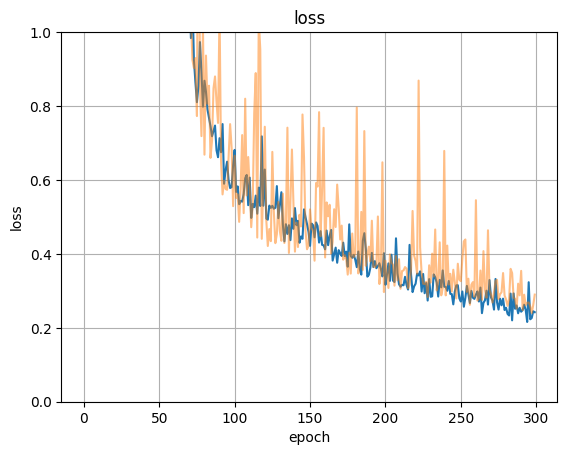

In [23]:
# Data for plotting
t = np.arange(0.0, len(classifier.train_losses), 1)
s = classifier.train_losses

fig, ax = plt.subplots()
ax.plot(t, s)

t = np.arange(0.0, len(classifier.test_losses), 1)
s = [x.item() for x in classifier.test_losses]
ax.plot(t, s, alpha=0.5)

ax.set(xlabel='epoch', ylabel='loss',
       title='loss')
ax.set_ylim([0, 1])
ax.grid()
#fig.text(0.5, -0.1, '''Train Error: Accuracy: 22.2%, Avg loss: 3.625307''', wrap=True, horizontalalignment='center', fontsize=12)

#fig.savefig("test.png")
plt.show()

correct: 0.6737545565006076


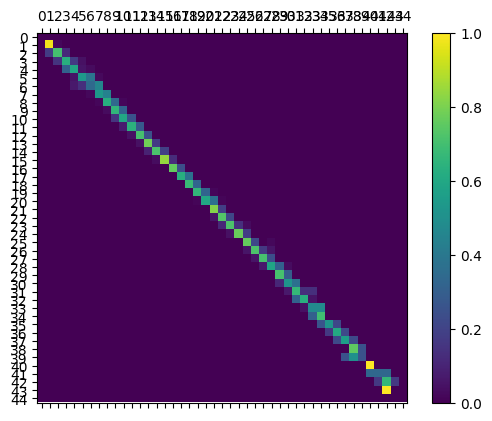

In [26]:
width = 43-1+3
confusion = torch.zeros(width, width)

preds = classifier.predict(X_test)
ys = y_test

correct_count = 0
for pred, true_meter in zip(preds, ys):
    guess_meter = round(pred)
    guess_meter = max(0, min(44, guess_meter))
    
    if true_meter == guess_meter:
        correct_count += 1
    confusion[int(true_meter)][int(guess_meter)] += 1
print(f"correct: {correct_count / len(ys)}")

# Normalize by dividing every row by its sum
for i in range(width):
    denom = confusion[i].sum()
    if denom > 0:
        confusion[i] = confusion[i] / denom

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
fig.colorbar(cax)

# Set up axes
ax.set_xticks(np.arange(width))
ax.set_yticks(np.arange(width))

# Force label at every tick
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()


In [30]:
inp = [[[bpm*4/60, np.log2(60/bpm*4*32+1)]] for bpm in range(10, 500, 10)]
print(inp)
out = classifier.predict(inp)
for i, r in enumerate(out):
    print(10+i*10, r)

[[[0.6666666666666666, np.float64(9.586839787961827)]], [[1.3333333333333333, np.float64(8.588714635582264)]], [[2.0, np.float64(8.005624549193879)]], [[2.6666666666666665, np.float64(7.592457037268081)]], [[3.3333333333333335, np.float64(7.272396509037485)]], [[4.0, np.float64(7.011227255423254)]], [[4.666666666666667, np.float64(6.7906975781039955)]], [[5.333333333333333, np.float64(6.599912842187128)]], [[6.0, np.float64(6.431845786965398)]], [[6.666666666666667, np.float64(6.281698250098829)]], [[7.333333333333333, np.float64(6.146047899424372)]], [[8.0, np.float64(6.022367813028454)]], [[8.666666666666666, np.float64(5.908739020000887)]], [[9.333333333333334, np.float64(5.803669875249748)]], [[10.0, np.float64(5.705977901682522)]], [[10.666666666666666, np.float64(5.614709844115208)]], [[11.333333333333334, np.float64(5.52908600252865)]], [[12.0, np.float64(5.448460500816294)]], [[12.666666666666666, np.float64(5.372292312063901)]], [[13.333333333333334, np.float64(5.3001237245690

In [35]:
RESOLUTION = 100
STREAM_BOUNDS = (1, 13)
BPM_BOUNDS = (1, 600)
x, y = np.meshgrid(
    np.linspace(BPM_BOUNDS[0], BPM_BOUNDS[1], RESOLUTION),
    np.linspace(STREAM_BOUNDS[0], STREAM_BOUNDS[1], RESOLUTION)
)
inp = np.reshape(np.dstack((x, y)), (-1, 2))
inp = [[[1, 6], [item[0]*4/60, np.log2(60/item[0]*4*(2**item[1])+1)], [1, 6]] for item in inp]
image = classifier.predict(inp)
image = np.array(image).reshape((RESOLUTION, RESOLUTION))
# out = classifier.model(torch.tensor(inp, dtype=torch.float32))
# out = out.detach().numpy().reshape((RESOLUTION, RESOLUTION)).round()

3.0345733165740967 43.76201248168945


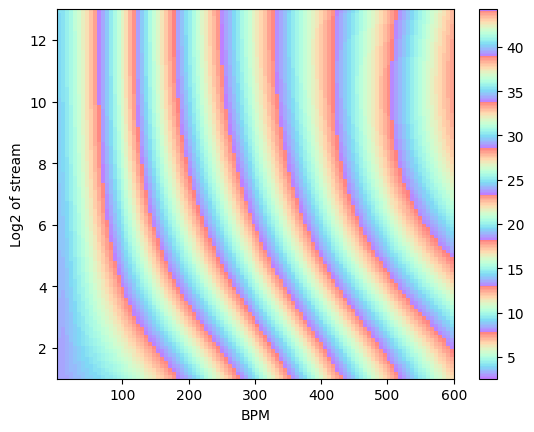

In [36]:
import matplotlib
from matplotlib.colors import ListedColormap, Normalize

vmin = np.min(image)
vmax = np.max(image)
print(vmin, vmax)
norm = Normalize(vmin=vmin-0.5, vmax=vmax+0.5)
#norm = Normalize(vmin=0, vmax=40)
cmap = matplotlib.colormaps['rainbow']
cmap = ListedColormap(cmap(np.linspace(0, 8, int(255)) % 1))

fig = plt.figure()
ax = fig.add_subplot()

#ax.view_init(elev=90, azim=-90, roll=0)
ax.set_xlabel('BPM')
ax.set_ylabel('Log2 of stream')
#ax.set_zlabel('Density')
pos = ax.imshow(image, origin='lower', cmap=cmap, alpha=0.5, extent=(*BPM_BOUNDS, *STREAM_BOUNDS),
          aspect='auto', norm=norm)
fig.colorbar(pos)
plt.show()